In [1]:
from six.moves import urllib
from scipy.io import loadmat
import os

mnist_path = os.path.join(".", "datasets", "mnist-original.mat")

if os.path.exists(mnist_path)==False:
    # download dataset from github.
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat" 
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)
else:
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Done!")

Done!


In [2]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [8]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt

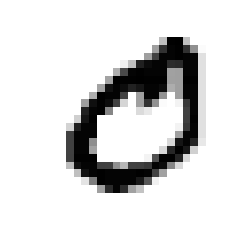

In [9]:
some_digit = X[1]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap= matplotlib.cm.binary, interpolation= "nearest")
plt.axis("off")
plt.show()

In [10]:
y[1]

0.0

### 1.将训练集与测试集分离

In [15]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
import numpy as np

In [14]:
#使用此函数来生成 0 - 59999之间不重复的随机排列
shuffle_index = np.random.permutation(60000) 
x_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### 2.简化问题
#### 2.1 训练一个二分类器

In [16]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test ==5)

In [27]:
from sklearn.linear_model import SGDClassifier
#随机梯度下降分类器并不是一个独立的算法，而是一系列利用随机梯度下降求解参数的算法的集合。

In [29]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)
# max_iter 被指定为算法训练epoch的次数
# tol 被指定为算法停止的标准。在0.21版本中，默认为1e-3

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [32]:
import sklearn
sklearn.__version__
#看起来以上的随机梯度下降分类器模型所使用参数是训练epoch=5就停止

'0.20.0'

In [33]:
sgd_clf.predict([some_digit])

array([False])

### 3.对性能的评估
#### 3.1使用交叉验证测量准确性

In [35]:
#使用第二章的知识对数据进行K折交叉检验
#并且我们往往希望测试集当中的数据与训练集当中的数据有相同的分布
#避免出现因为测试集中包含某一类样本过多使得精度度量失去意义 使用分层抽样解决此问题
#此时分层抽样的依据往往是训练样本中的label分布
#分层抽样在进行训练集与测试集分离以及进行交叉检验时都有涉及，需要注意
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [39]:
skfolds = StratifiedKFold(n_splits = 3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    